# Random Forest Regressor to predict Attendance (using Scitkit-learn, PyMySQl SQLAlchemy, MySQL)

In [1]:
#import libraries/dependencies
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sqlalchemy import create_engine
import pymysql

In [2]:
#import login credentials. This file is ignored via the gitignore file
from config import user, password

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import create_engine, MetaData
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Numeric, Text, Float, Date

In [4]:
#create connection to MySQL Database
pymysql.install_as_MySQLdb()
engine = create_engine('mysql://' + user + ':' + password + '@imdb-project.cj1m13sfkxlg.us-east-2.rds.amazonaws.com:3306/baseball')

# Data Processing

In [5]:
#use pandas for reading data from your MySQL server:
df = pd.read_sql('SELECT * FROM Dodgers', con=engine)

In [35]:
#SQL query to get our df

query= """
SELECT Game as Game_ID, `Number` as Opponent_Number,
REPLACE(LEFT(YYYYMMDD,10),'-','') as Date,
CASE WHEN DAYOFWEEK(YYYYMMDD)= 1 OR DAYOFWEEK(YYYYMMDD) = 7 THEN '1' ELSE '0' END as Is_Weekend,
Month(YYYYMMDD) as Month,
Year(YYYYMMDD) as Year,
CASE WHEN `D/N` = 'D' THEN 1 ELSE 0 END as Is_Day, 
LENGTH(Streak) - LENGTH(REPLACE(Streak,'+','')) as Win_Streak,
`W-L`,
Bobble_head,
precip,
Temp,
Attendance
FROM Dodgers_data as dodger
LEFT JOIN Opponent_Map as map on dodger.Opponent = map.Opponent
"""

In [7]:
#Change 'Attendance' to integer
df2 = pd.read_sql_query(query,engine)
df2['Attendance'] = df2['Attendance'].str.replace(',', '')
df2['Attendance'] = df2['Attendance'].astype(int)
df2.drop('Date', axis=1, inplace=True)
df2.head()

,Game_ID,Opponent_Number,Is_Weekend,Month,Year,Is_Day,Win_Streak,W-L,Bobble_head,precip,Temp,Attendance
0,1,1,0,4,2017,1,1,01-00,0,0.0,60.0,53701
1,2,1,0,4,2017,0,0,01-01,0,0.0,62.0,42196
2,3,1,0,4,2017,0,1,02-01,0,0.0,67.0,38373
3,4,1,0,4,2017,1,2,03-01,0,0.0,66.0,36501
4,115,1,0,8,2017,0,0,81-34,0,0.0,86.0,52898


In [8]:
#remove/reformat null values from W-L column
Winning_Per = [] 
Win_Per = []
for element in df2["W-L"]:
   
    Winning_Per.append(element.replace('-', ' ').split(' '))
    
for thing in Winning_Per:
    Win_Per.append(float(thing[0]) /(float(thing[0]) + float(thing[1])))

In [44]:
#Let's use the modified Win Percentage input data we just created
df2["Win_Per"] = Win_Per

In [10]:
#targeting Attendance
target = df2["Attendance"]
target_names = ["Attendance"]

In [11]:
#drop Attendance
df3 = df2.drop("Attendance", axis=1)
feature_names = df3.columns
df3.head(5)

,Game_ID,Opponent_Number,Is_Weekend,Month,Year,Is_Day,Win_Streak,W-L,Bobble_head,precip,Temp,Win_Per
0,1,1,0,4,2017,1,1,01-00,0,0.0,60.0,1.000000
1,2,1,0,4,2017,0,0,01-01,0,0.0,62.0,0.500000
2,3,1,0,4,2017,0,1,02-01,0,0.0,67.0,0.666667
3,4,1,0,4,2017,1,2,03-01,0,0.0,66.0,0.750000
4,115,1,0,8,2017,0,0,81-34,0,0.0,86.0,0.704348


In [12]:
df4 = df3.drop("W-L", axis=1)
feature_names = df4.columns
df4.head()

,Game_ID,Opponent_Number,Is_Weekend,Month,Year,Is_Day,Win_Streak,Bobble_head,precip,Temp,Win_Per
0,1,1,0,4,2017,1,1,0,0.0,60.0,1.000000
1,2,1,0,4,2017,0,0,0,0.0,62.0,0.500000
2,3,1,0,4,2017,0,1,0,0.0,67.0,0.666667
3,4,1,0,4,2017,1,2,0,0.0,66.0,0.750000
4,115,1,0,8,2017,0,0,0,0.0,86.0,0.704348


In [13]:
#Drop Yer (was overweighting model)
df5 = df4.drop("Year", axis=1)
feature_names = df5.columns
df5.head()

,Game_ID,Opponent_Number,Is_Weekend,Month,Is_Day,Win_Streak,Bobble_head,precip,Temp,Win_Per
0,1,1,0,4,1,1,0,0.0,60.0,1.000000
1,2,1,0,4,0,0,0,0.0,62.0,0.500000
2,3,1,0,4,0,1,0,0.0,67.0,0.666667
3,4,1,0,4,1,2,0,0.0,66.0,0.750000
4,115,1,0,8,0,0,0,0.0,86.0,0.704348


# Random Forest Regressor

In [14]:
#import Sklearn model and train_test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df5, target)

In [15]:
# Create a random forest regressor
rf = RandomForestRegressor(n_estimators=1000)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.38813609288290873

# Feature Importances

In [17]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf.feature_importances_
importances

array([0.1647847 , 0.11497927, 0.03909063, 0.03041605, 0.02512418,
       0.04440792, 0.05641541, 0.04258731, 0.15094872, 0.33124581])

In [18]:
#declare feature names
feature_names= "Game_ID", "Opponent_Number", "Is_Weekend", "Month", "Is_Day", "Win_Streak", "Bobble_head", "precip","Temp", "Win_Per"

In [19]:
# We can sort the features by their importance
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

[(0.3312458085024503, 'Win_Per'),
 (0.16478469765317386, 'Game_ID'),
 (0.15094872106128235, 'Temp'),
 (0.11497927015227191, 'Opponent_Number'),
 (0.056415413695159296, 'Bobble_head'),
 (0.044407920418250334, 'Win_Streak'),
 (0.042587309365941885, 'precip'),
 (0.03909063290514322, 'Is_Weekend'),
 (0.030416048297802013, 'Month'),
 (0.025124177948524812, 'Is_Day')]

# Pie Chart for feature importances

In [20]:
#import Matplotlib
import matplotlib.pyplot as plt

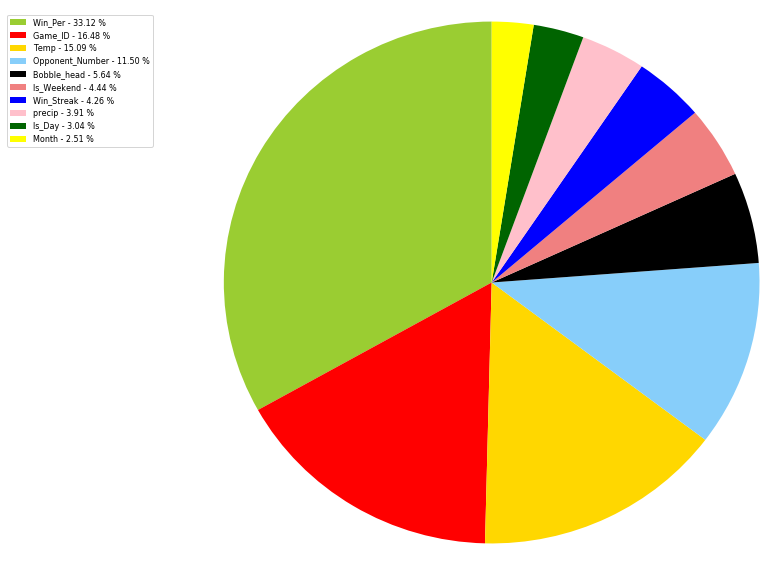

In [75]:
#Set parameters for Pie Chart
import matplotlib.pyplot as plt
import numpy as np

# Where to change the size
plt.figure(figsize=(10,10))

x = np.char.array(['Win_Per','Game_ID', 'Temp', 'Opponent_Number', 'Bobble_head', 'Is_Weekend', 'Win_Streak', 'precip', 'Is_Day', 'Month'])
y = np.array([0.3312458085024503, 0.16478469765317386, 0.15094872106128235, 0.11497927015227191, 0.056415413695159296, 0.044407920418250334,  0.042587309365941885, 0.03909063290514322, 0.030416048297802013, 0.025124177948524812])
colors = ['yellowgreen','red','gold','lightskyblue','black','lightcoral','blue','pink', 'darkgreen','yellow']
porcent = 100.*y/y.sum()

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)

plt.savefig('Piechart.png')
plt.show()

In [64]:
#Save Pie chart as png
plt.savefig('Piechart.png')

# Save dataframe to CSV for Tableau visualizations

In [34]:
#Save df as csv for Tableau visualizations
df2.to_csv("output.csv", index=False)

# Predict  attendance for win streaks of 0-5

In [53]:
preds = []
for win_streak in range(5):
    pred = [1, 2, 1, 5, 1, win_streak, 0, 0.0, 75.0, 0.6]
    preds.append(pred)
rf.predict(preds)

array([47229.726, 47005.205, 46870.715, 46763.99 , 46980.118])